<a href="https://colab.research.google.com/github/mayatahir/ECGR-5105/blob/master/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4 (100 Points)

In this homework, we will use the cancer dataset. (Note: You can use the built-in function from ML libraries for gradient descent, training, and validation.) Also, sample code for accessing and cleaning up the dataset provided in Canvas. For the evaluation of this homework across all problems, use 80%, 20% split. We will also use US Housing dataset with 80% and 20% split between training and evaluation (test) sets.

In [37]:
#Importing Relevant Libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.svm import SVR


from sklearn.datasets import load_breast_cancer

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
def get_results(y_test, Y_pred):
    acc = metrics.accuracy_score(y_test, Y_pred)
    pre = metrics.precision_score(y_test, Y_pred)
    rec = metrics.recall_score(y_test, Y_pred)
    fscore = metrics.f1_score(y_test, Y_pred)
    print("Accuracy:",metrics.accuracy_score(y_test, Y_pred))
    print("Precision:",metrics.precision_score(y_test, Y_pred))
    print("Recall:",metrics.recall_score(y_test, Y_pred))
    print("F1-Score:",metrics.f1_score(y_test, Y_pred))
    return [acc*100.0, pre*100.0, rec*100.0, fscore*100.0]

def classification_training_pca(X, Y, classifier):
    n=X.shape[1]
    acc_list=[]
    recall_list=[]
    precision_list=[]
    f1score_list = []
    k_list=[]
    for i in range(n):
        print("K = "+ str(i+1))
        pca = PCA(n_components=i+1)
        principalComponents = pca.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, test_size=0.20, random_state=9999)
        classifier.fit(X_train, y_train)
        Y_pred = classifier.predict(X_test)
        re = get_results(y_test, Y_pred)
        acc_list.append(re[0])
        precision_list.append(re[1])
        recall_list.append(re[2])
        f1score_list.append(re[3])
        k_list.append(i+1)
    high_acc = max(acc_list)
    high_acc_k=acc_list.index(max(acc_list))+1
    print("----------------")
    print("Highest Classification Accuracy Achieved: "+ str(high_acc)+" for K number = "+str(high_acc_k))
    return k_list, acc_list, precision_list, recall_list, f1score_list

def plot_classification_result(k_list, acc_list, precision_list, recall_list, f1score_list, title=''):
    plt.figure(figsize=(15,10)) # New figure
    lw = 1 # line width
    plt.plot(k_list, acc_list, label = "Accuracy")
    plt.plot(k_list, precision_list, label = "Precision")
    plt.plot(k_list, recall_list, label = "Recall")
    plt.plot(k_list, f1score_list, label = "F1-Score")
    plt.legend()
    if not title:
        plt.title('Classification accuracy, precision, recall and F1-score')
    else:
        plt.title(title)
    plt.ylabel('Value')
    plt.xlabel('K')
    plt.show()

def regression_training_pca(X, Y, model):
    n = X.shape[1]
    mse_list=[]
    k_list=[]
    for i in range(n):
        print("K = "+ str(i+1))
        pca = PCA(n_components=i+1)
        principalComponents = pca.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, test_size=0.20, random_state=9999)
        model.fit(X_train, y_train)
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, Y_pred)
        mse_list.append(mse)
        print('MSE: ', mse)
        k_list.append(i+1)
    min_mse = min(mse_list)
    min_mse_k = mse_list.index(min(mse_list)) + 1
    print("----------------")
    print("Mean Squared Error Achieved: "+ str(min_mse)+" for K number = "+str(min_mse_k))
    return k_list, mse_list

def plot_regression_result(k_list, mse_list, title=''):
    plt.figure(figsize=(15,10)) # New figure
    lw = 1 # line width
    plt.plot(k_list, mse_list, color='red', label = "Mean Square Error")
    plt.legend()
    if not title:
        plt.title('Mean Square Error')
    else:
        plt.title(title)
    plt.ylabel('MSE')
    plt.xlabel('K')
    plt.show()

def plot_model(X, y, theta, x_label, y_label, title ):

    # New figure
    plt.figure(figsize=(15,10))
    lw = 1 # line width

    # Scatter plot for the training data
    plt.scatter(X[:, 1], y, color='red', marker='+', label='Training Data')

    # Line plot for the linear regression model
    plt.plot(X[:, 1], X.dot(theta), color='green', label='Support Vector Regression')

    # Plot customizations
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.grid(True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

## Problem 1 (50pts):
Use the cancer dataset to build an SVM classifier to classify the type of cancer (Malignant vs. benign). Use the PCA feature extraction for your training. Perform N number of independent training (N=1, …, K).

1. Identify the optimum number of K, principal components that achieve the highest classification accuracy.
2. Plot your classification accuracy, precision, and recall over a different number of Ks.
3. Explore different kernel tricks to capture non-linearities within your data. Plot the results and compare the accuracies for different kernels.
4. Compare your results against the logistic regression that you have done in homework 3.


Make sure to explain and elaborate your results.

In [40]:
breast = load_breast_cancer()
X = breast.data
print(X.shape)
Y = breast.target

breast_input = pd.DataFrame(X)
print(breast_input)

(569, 30)
        0      1       2       3        4        5        6        7       8   \
0    17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010  0.14710  0.2419   
1    20.57  17.77  132.90  1326.0  0.08474  0.07864  0.08690  0.07017  0.1812   
2    19.69  21.25  130.00  1203.0  0.10960  0.15990  0.19740  0.12790  0.2069   
3    11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140  0.10520  0.2597   
4    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800  0.10430  0.1809   
..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
564  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390  0.13890  0.1726   
565  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400  0.09791  0.1752   
566  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251  0.05302  0.1590   
567  20.60  29.33  140.10  1265.0  0.11780  0.27700  0.35140  0.15200  0.2397   
568   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000  0.00000  0.1587   

          9   ...

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1.1. Optimum number of K, principal components that achieve the highest classification accuracy

In [42]:
k_list, acc_list, precision_list, recall_list, f1score_list  = classification_training_pca(X,Y, SVC(kernel='linear'))

K = 1
Accuracy: 0.9122807017543859
Precision: 0.9146341463414634
Recall: 0.9615384615384616
F1-Score: 0.9375000000000001
K = 2
Accuracy: 0.956140350877193
Precision: 0.9620253164556962
Recall: 0.9743589743589743
F1-Score: 0.9681528662420382
K = 3
Accuracy: 0.956140350877193
Precision: 0.9620253164556962
Recall: 0.9743589743589743
F1-Score: 0.9681528662420382
K = 4
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 5
Accuracy: 0.9473684210526315
Precision: 0.9736842105263158
Recall: 0.9487179487179487
F1-Score: 0.9610389610389611
K = 6
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 7
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 8
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 9
Accuracy: 0.9473684210526315
Precision: 

### 1.2. Classification accuracy, precision, and recall over a different number of Ks.

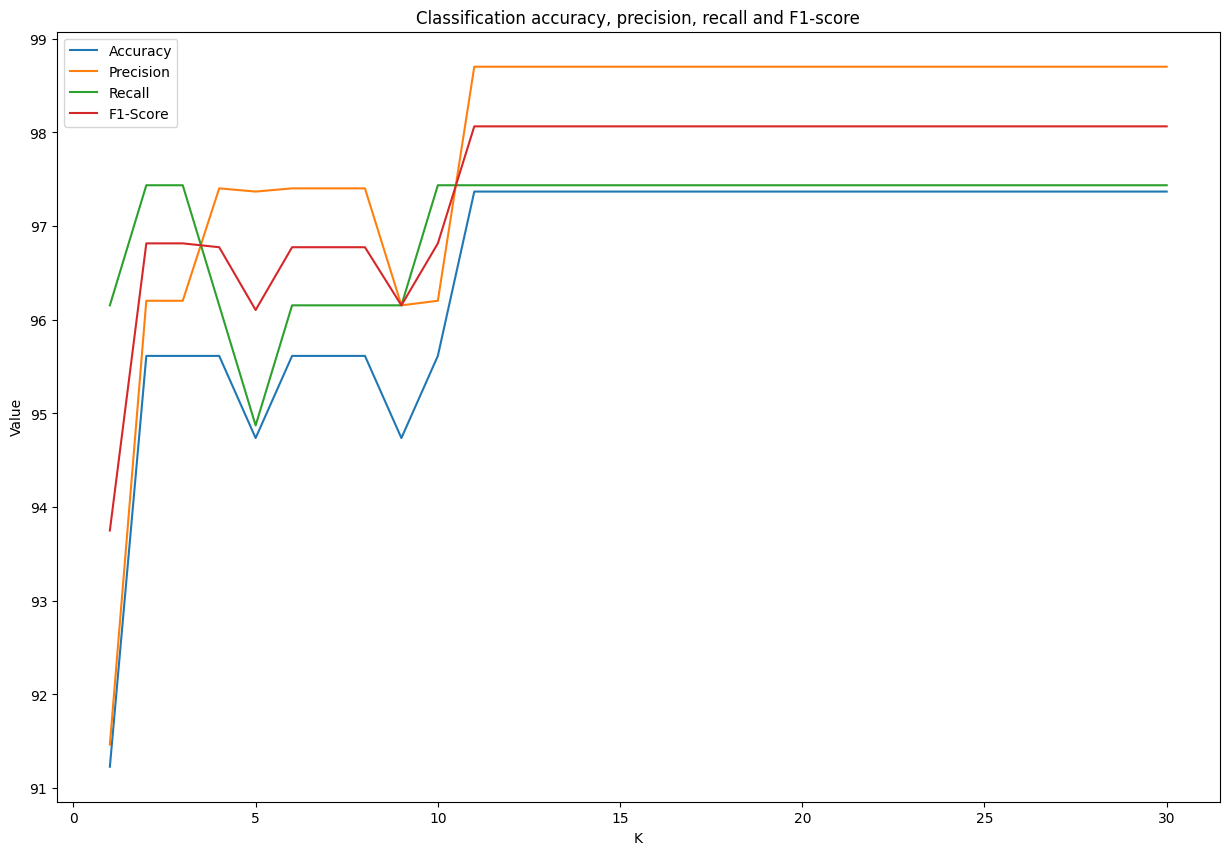

In [43]:
plot_classification_result(k_list, acc_list, precision_list, recall_list, f1score_list)

### 1.3. Exploring different kernel tricks to capture non-linearities within data.

Training rbf
K = 1
Accuracy: 0.6666666666666666
Precision: 0.7040816326530612
Recall: 0.8846153846153846
F1-Score: 0.7840909090909091
K = 2
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 3
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 4
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 5
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 6
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 7
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 8
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 9
Accuracy: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 1.0
F1-Score: 0.8125000000000001
K = 10
Accuracy: 0

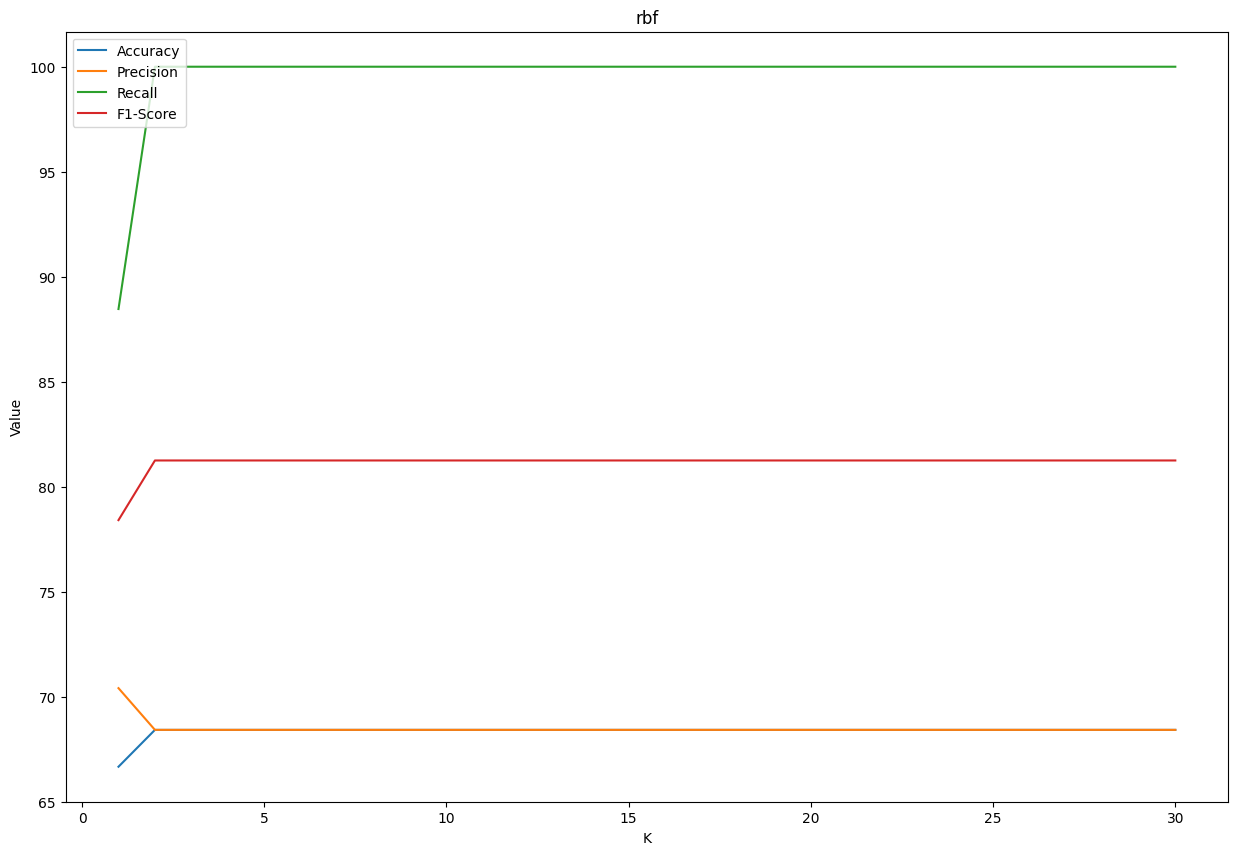

Training linear
K = 1
Accuracy: 0.9122807017543859
Precision: 0.9146341463414634
Recall: 0.9615384615384616
F1-Score: 0.9375000000000001
K = 2
Accuracy: 0.956140350877193
Precision: 0.9620253164556962
Recall: 0.9743589743589743
F1-Score: 0.9681528662420382
K = 3
Accuracy: 0.956140350877193
Precision: 0.9620253164556962
Recall: 0.9743589743589743
F1-Score: 0.9681528662420382
K = 4
Accuracy: 0.9473684210526315
Precision: 0.9736842105263158
Recall: 0.9487179487179487
F1-Score: 0.9610389610389611
K = 5
Accuracy: 0.9473684210526315
Precision: 0.9736842105263158
Recall: 0.9487179487179487
F1-Score: 0.9610389610389611
K = 6
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 7
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 8
Accuracy: 0.956140350877193
Precision: 0.974025974025974
Recall: 0.9615384615384616
F1-Score: 0.967741935483871
K = 9
Accuracy: 0.956140350

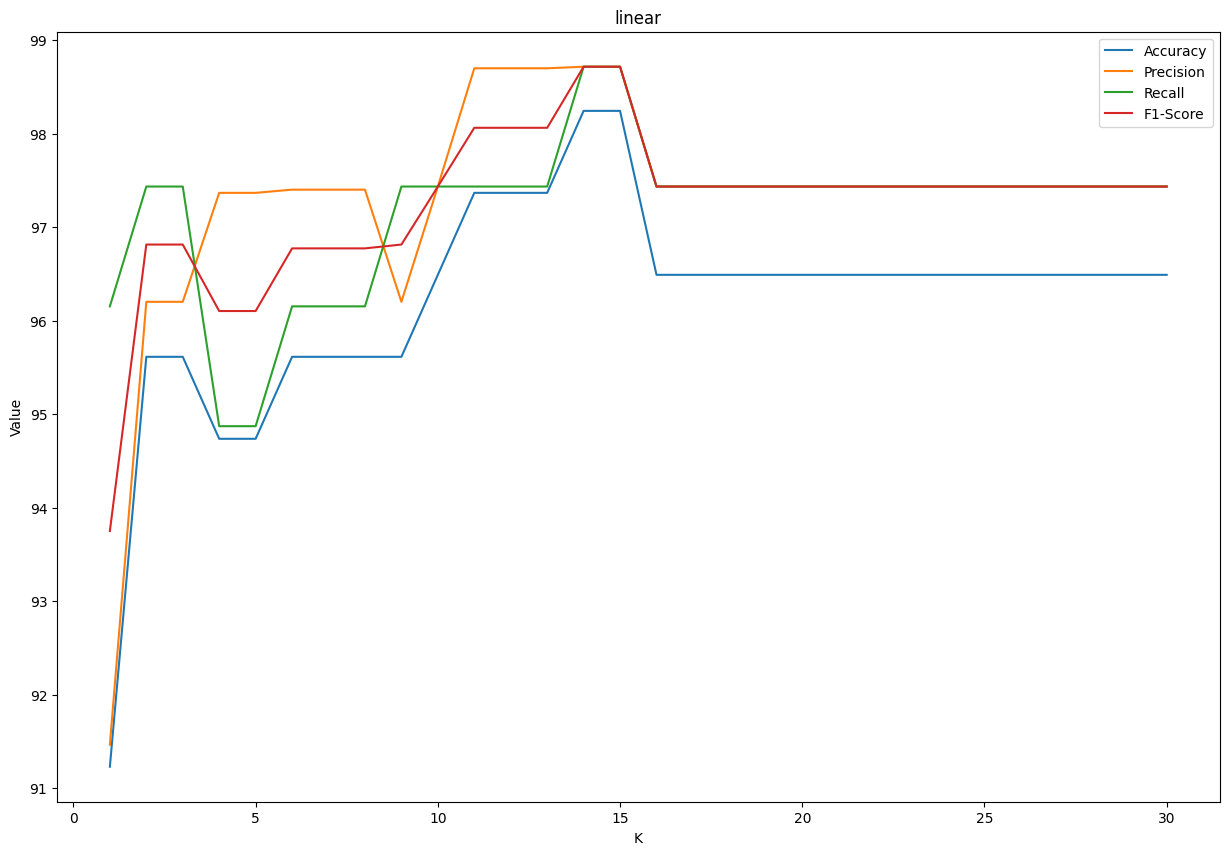

Training poly
K = 1
Accuracy: 0.8157894736842105
Precision: 0.7878787878787878
Recall: 1.0
F1-Score: 0.8813559322033898
K = 2
Accuracy: 0.8333333333333334
Precision: 0.8390804597701149
Recall: 0.9358974358974359
F1-Score: 0.8848484848484849
K = 3
Accuracy: 0.868421052631579
Precision: 0.8620689655172413
Recall: 0.9615384615384616
F1-Score: 0.9090909090909091
K = 4
Accuracy: 0.868421052631579
Precision: 0.8620689655172413
Recall: 0.9615384615384616
F1-Score: 0.9090909090909091
K = 5
Accuracy: 0.8771929824561403
Precision: 0.8809523809523809
Recall: 0.9487179487179487
F1-Score: 0.9135802469135802
K = 6
Accuracy: 0.8947368421052632
Precision: 0.8928571428571429
Recall: 0.9615384615384616
F1-Score: 0.9259259259259259
K = 7
Accuracy: 0.8859649122807017
Precision: 0.8823529411764706
Recall: 0.9615384615384616
F1-Score: 0.920245398773006
K = 8
Accuracy: 0.8859649122807017
Precision: 0.8823529411764706
Recall: 0.9615384615384616
F1-Score: 0.920245398773006
K = 9
Accuracy: 0.8947368421052632
Pr

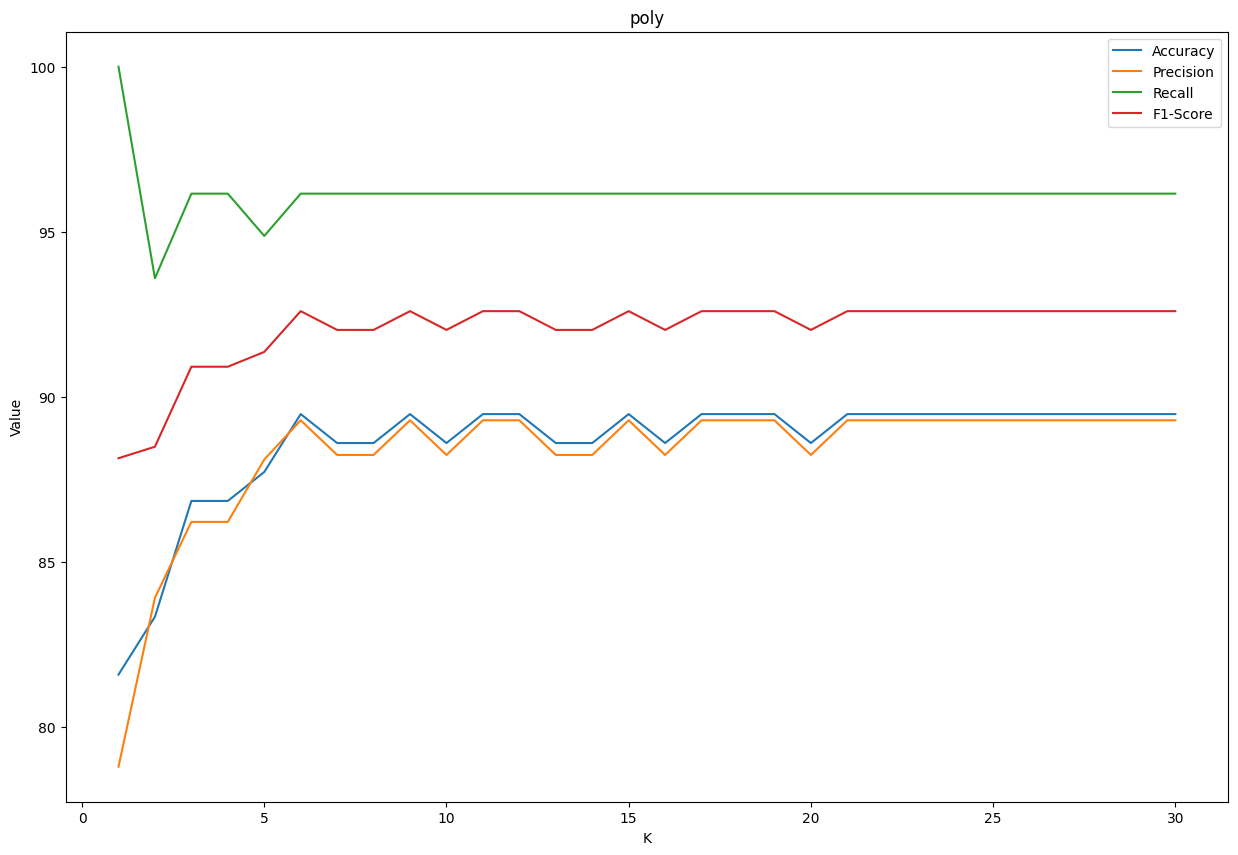

In [44]:
# Kernelization example
kernels = {"rbf": SVC(kernel='rbf', C=1E5, gamma=0.1),
           "linear": SVC(kernel='linear', C=1e1),
           "poly": SVC(kernel='poly', C=1E5, degree=2)
            }

for kernel, svc in kernels.items():
    print("Training " + kernel)
    k_list, acc_list, precision_list, recall_list, f1score_list  = classification_training_pca(X,Y, svc)
    plot_classification_result(k_list, acc_list, precision_list, recall_list, f1score_list, kernel)


### 1.4. Compare results against the logistic regression in homework 3

See report

## Problem 2 (50pts):

Develop a SVR regression model that predicts housing price based on the following input variables:

Area, bedrooms, bathrooms, stories, mainroad, guestroom, basement, hotwaterheating, airconditioning, parking, prefarea

1. Plot your regression model for SVR similar to the sample code provided on Canvas.
2. Compare your results against linear regression with regularization loss that you already did in homework1.
3. Use the PCA feature extraction for your training. Perform N number of independent training (N=1, …, K). Identify the optimum number of K, principal components that achieve the highest regression accuracy.
4. Explore different kernel tricks to capture non-linearities within your data. Plot the results and compare the accuracies for different kernels.

In [45]:
# Read dataset
csv_file = '/content/gdrive/My Drive/Housing.csv'
# csv_file = './Housing.csv'
df = pd.read_csv(csv_file)

# Print dataset summary
print(df)
df.shape

        price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
540   1820000  3000         2          1        1      yes        no      yes   
541   1767150  2400         3          1        1       no        no       no   
542   1750000  3620         2          1        1      yes        no       no   
543   1750000  2910         3          1        1       no        no       no   
544   1750000  3850         3          1        2      yes        no       no   

    hotwaterheating aircond

(545, 13)

In [46]:
# List of variables to map
binary_features =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
ternary_features = ['furnishingstatus']

# Defining the map functions
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

def ternary_map(x):
    return x.map({'furnished':2, 'semi-furnished':1, 'unfurnished':0})

# Applying the function to the housing list
df[binary_features] = df[binary_features].apply(binary_map)
df[ternary_features] = df[ternary_features].apply(ternary_map)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [47]:
# Standardizing the data
scaler = StandardScaler()
num_vars = ['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea']
all_vars = ['price'] + num_vars
df_norm = df.copy() # copy df to not modify orignal data frame
df_norm[all_vars] = scaler.fit_transform(df_norm[all_vars])

# Visualizing the data
df_split = df_norm[all_vars]
df_split.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea
0,4.566365,1.046726,1.403419,1.421812,1.378217,0.405623,-0.465315,-0.734539,-0.219265,1.472618,1.517692,1.804941
1,4.004484,1.757010,1.403419,5.405809,2.532024,0.405623,-0.465315,-0.734539,-0.219265,1.472618,2.679409,-0.554035
2,4.004484,2.218232,0.047278,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,1.804941
3,3.985755,1.083624,1.403419,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,1.472618,2.679409,1.804941
4,3.554979,1.046726,1.403419,-0.570187,0.224410,0.405623,2.149083,1.361397,-0.219265,1.472618,1.517692,-0.554035


In [48]:
# Converting dataframe to numpy
X = df_norm[num_vars].to_numpy()
Y = df_norm['price'].to_numpy()

### 2.1. Plotting regression model for SVR

In [49]:
# Training model with all the data
svr_rbf = SVR(kernel='rbf', C=1e2, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e1)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, Y).predict(X)
y_lin = svr_lin.fit(X, Y).predict(X)
y_poly = svr_poly.fit(X, Y).predict(X)

print("MSE_rbf: %.2f" % mean_squared_error(Y, y_rbf))
print("MSE_lin: %.2f" % mean_squared_error(Y, y_lin))
print("MSE_poly: %.2f" % mean_squared_error(Y, y_poly))

MSE_rbf: 0.06
MSE_lin: 0.34
MSE_poly: 0.39


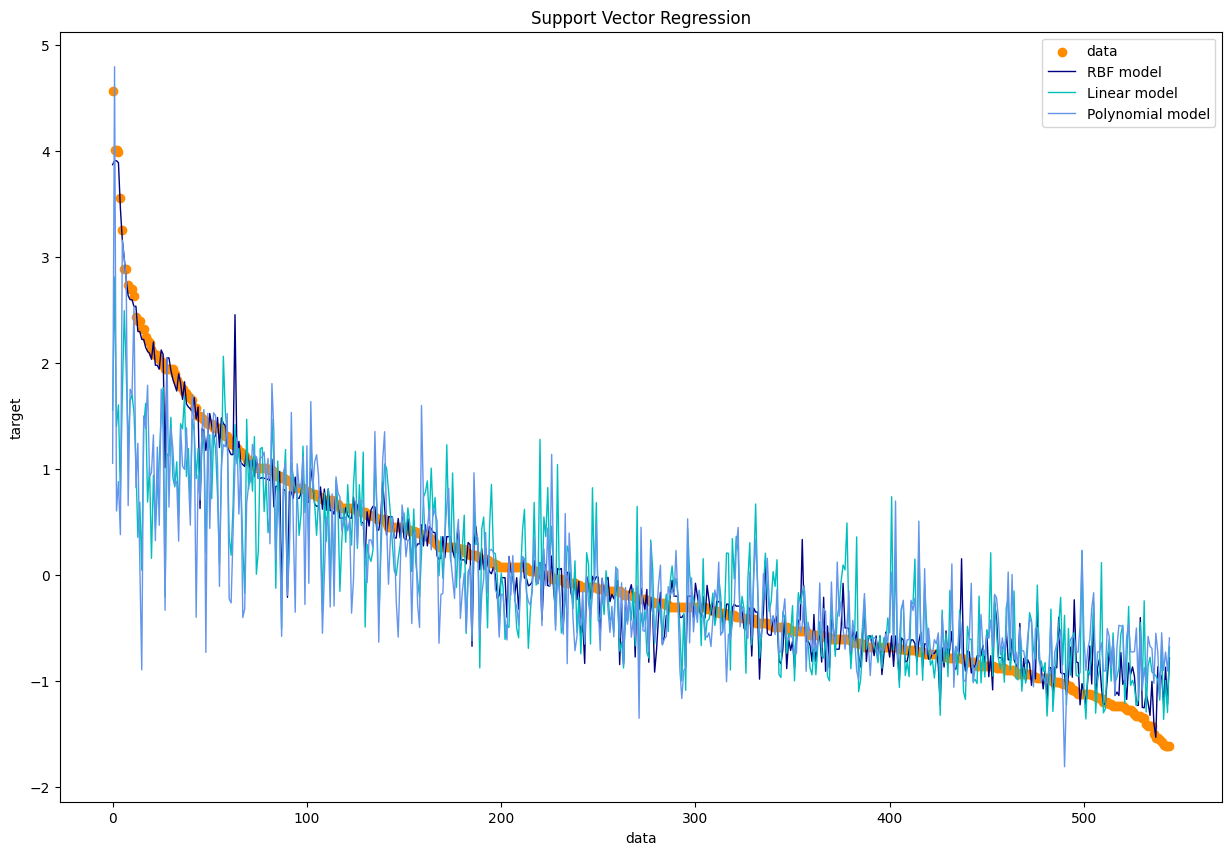

In [50]:
# Plotting SVR model
plt.figure(figsize=(15,10)) # New figure
lw = 1 # line width
plt.scatter(range(len(Y)), Y, color='darkorange', lw=lw, label='data')
plt.plot(range(len(y_rbf)), y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(range(len(y_lin)), y_lin, color='c', lw=lw, label='Linear model')
plt.plot(range(len(y_poly)), y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()


### 2.2. Compare your results with linear regression with regularization done in homework 2:

See report

### 2.3. Use the PCA feature extraction for your training

K = 1
MSE:  0.3530191268965167
K = 2
MSE:  0.3962526203385084
K = 3
MSE:  0.37834302948047943
K = 4
MSE:  0.5370000578931009
K = 5
MSE:  0.5758490691788735
K = 6
MSE:  0.475312081104738
K = 7
MSE:  0.5518686368518694
K = 8
MSE:  0.49787942477252134
K = 9
MSE:  0.6181415783513506
K = 10
MSE:  0.5338669780262563
K = 11
MSE:  0.5067169877597946
----------------
Mean Squared Error Achieved: 0.3530191268965167 for K number = 1


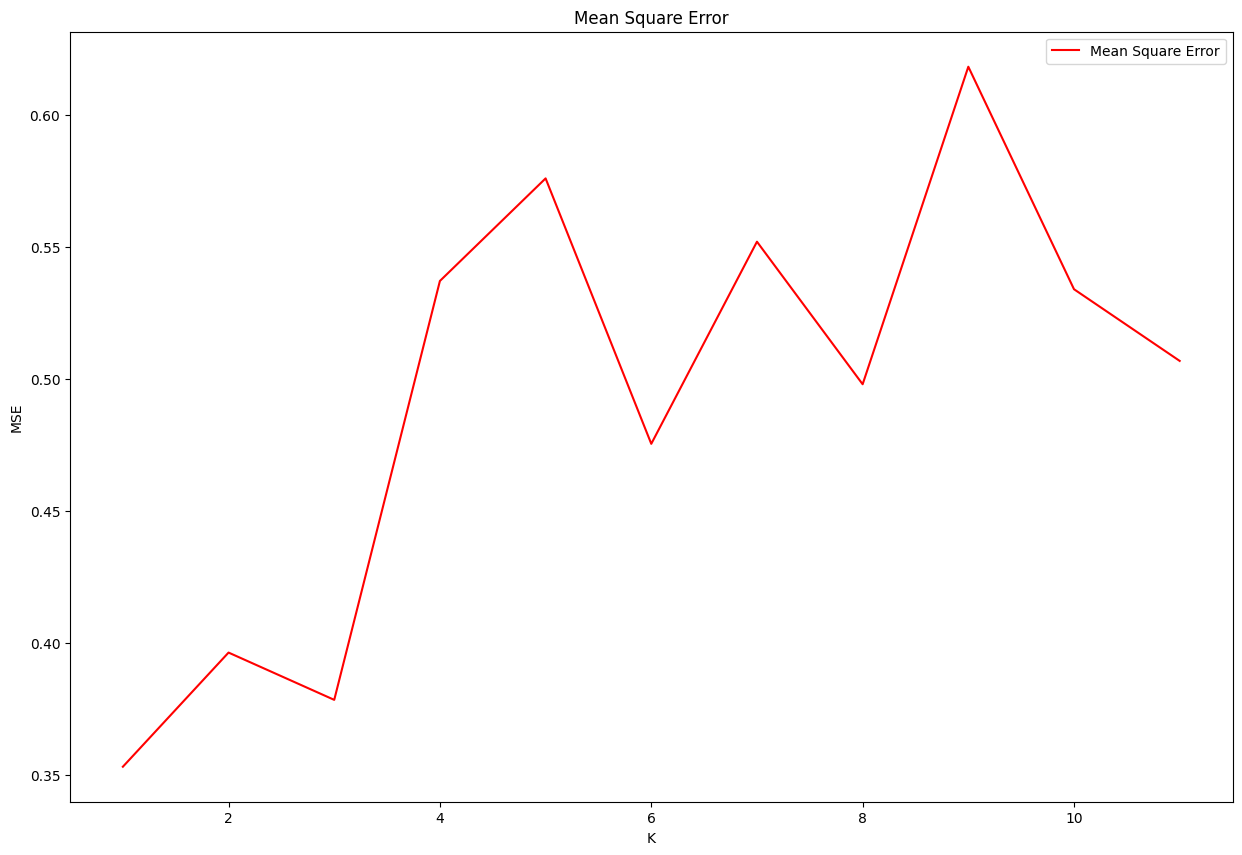

In [51]:
k_list, mse_list  = regression_training_pca(X, Y, svr_rbf)
plot_regression_result(k_list, mse_list)

### 2.4. Explore different kernel tricks to capture non-linearities within your data

Training rbf
K = 1
MSE:  0.3530191268964633
K = 2
MSE:  0.39625262033840913
K = 3
MSE:  0.3783430294805003
K = 4
MSE:  0.5370000578930236
K = 5
MSE:  0.5758490691786983
K = 6
MSE:  0.4753120811047856
K = 7
MSE:  0.5518686368518491
K = 8
MSE:  0.4978794247725091
K = 9
MSE:  0.6181415783513506
K = 10
MSE:  0.5338669780262563
K = 11
MSE:  0.5067169877597946
----------------
Mean Squared Error Achieved: 0.3530191268964633 for K number = 1


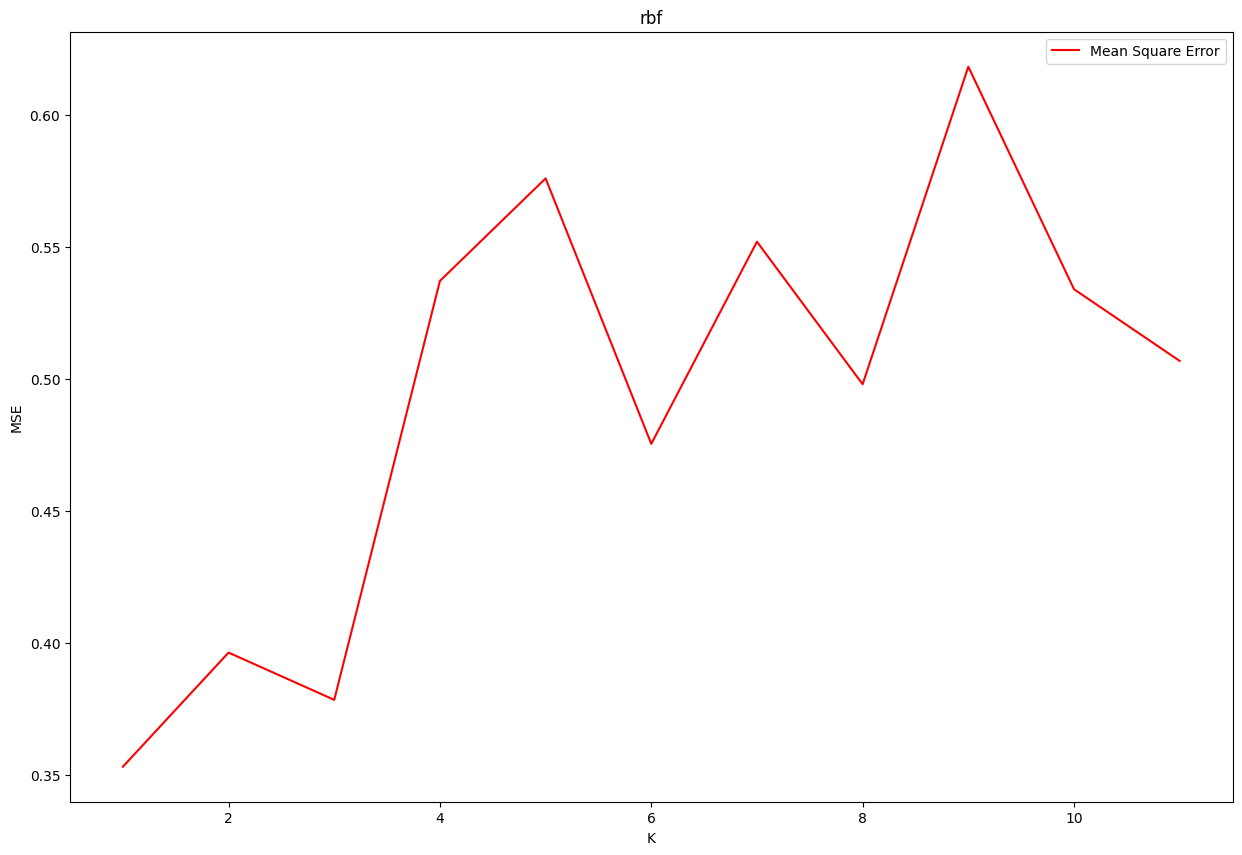

Training linear
K = 1
MSE:  0.35301795178678674
K = 2
MSE:  0.36378115837132585
K = 3
MSE:  0.36427958034450136
K = 4
MSE:  0.36959133076043005
K = 5
MSE:  0.37426917215455696
K = 6
MSE:  0.3738331950506041
K = 7
MSE:  0.3980677064616661
K = 8
MSE:  0.38721904429085596
K = 9
MSE:  0.3499848050332132
K = 10
MSE:  0.36200940803697756
K = 11
MSE:  0.3405250381575255
----------------
Mean Squared Error Achieved: 0.3405250381575255 for K number = 11


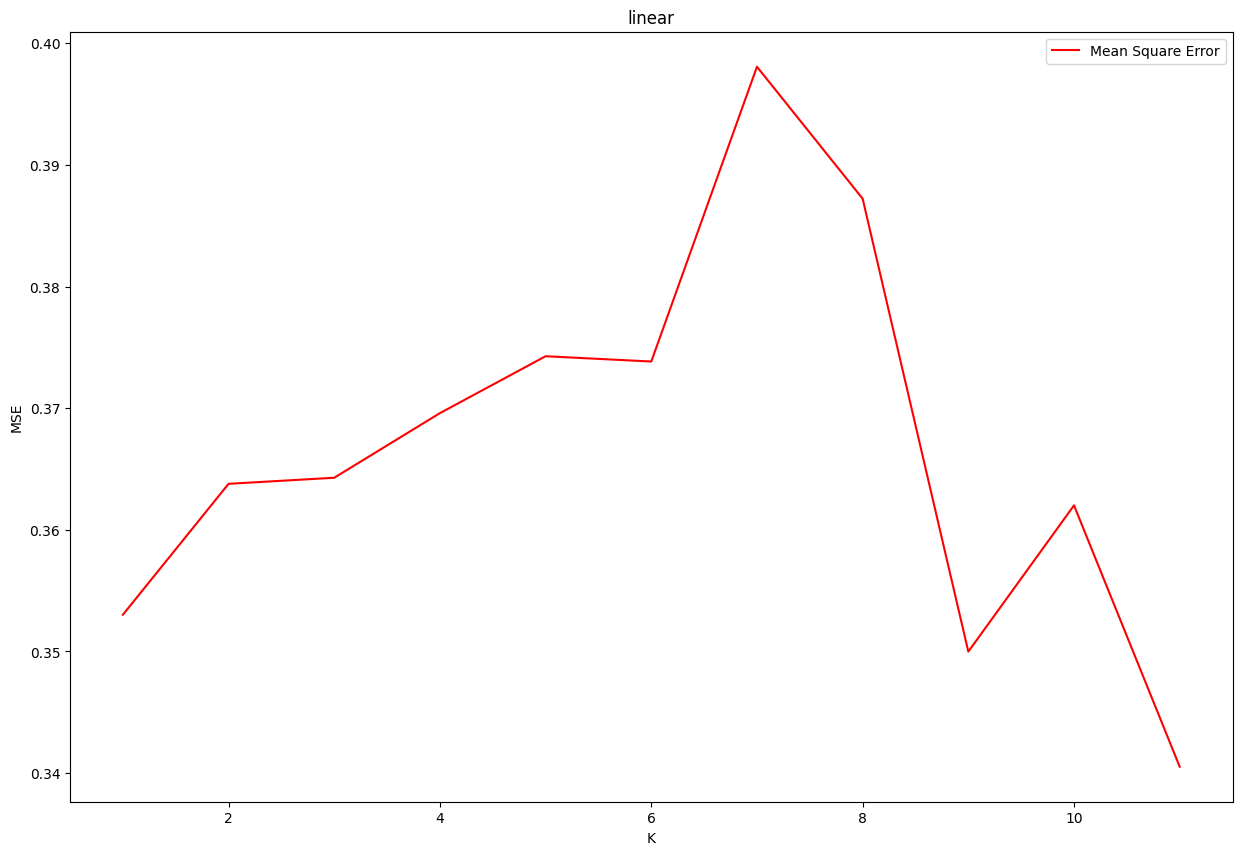

Training poly
K = 1
MSE:  0.8411940873632826
K = 2
MSE:  0.6866708216861775
K = 3
MSE:  0.699441245808694
K = 4
MSE:  0.9550143876399216
K = 5
MSE:  0.9267207922526992
K = 6
MSE:  0.8667127165613466
K = 7
MSE:  0.6896912876577409
K = 8
MSE:  0.7037786328855302
K = 9
MSE:  0.5446131635324598
K = 10
MSE:  0.8593495419599735
K = 11
MSE:  0.808310484161822
----------------
Mean Squared Error Achieved: 0.5446131635324598 for K number = 9


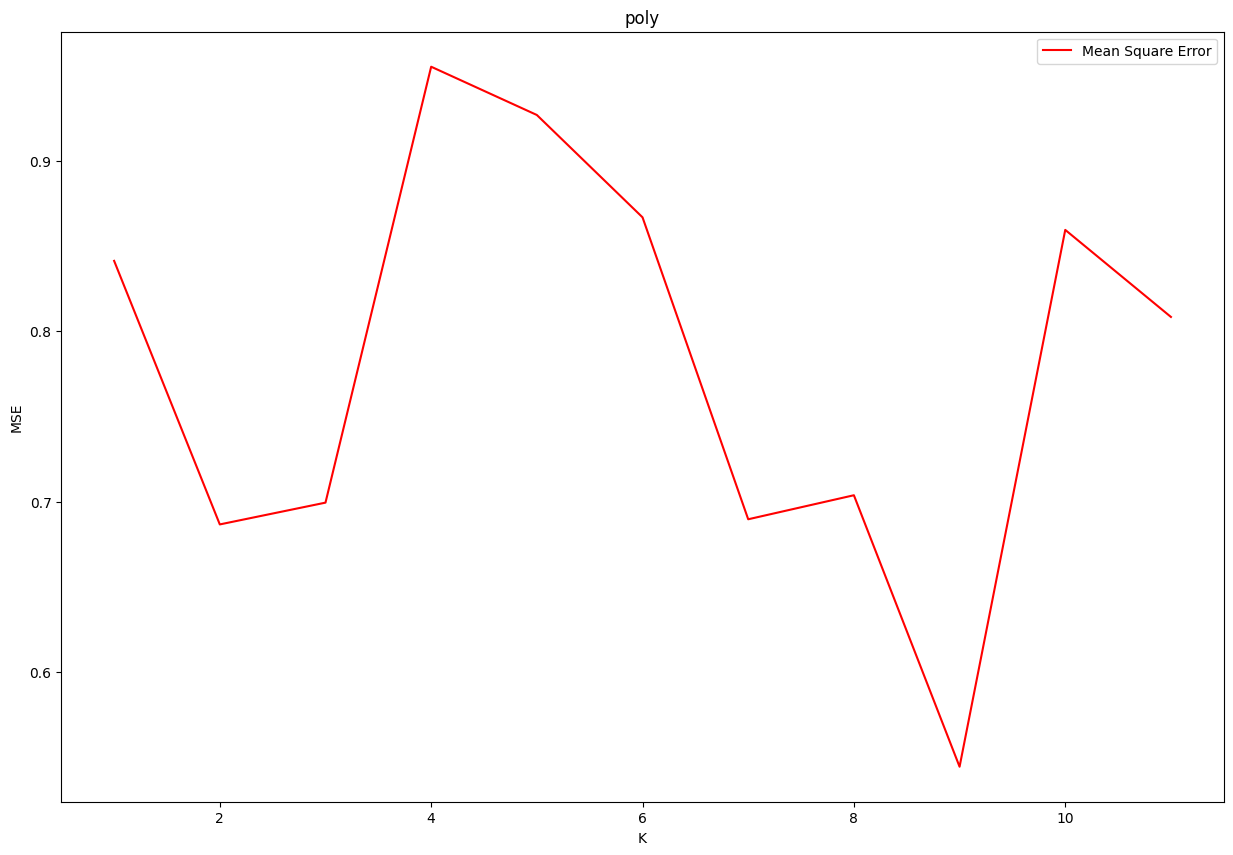

In [52]:
kernels = {"rbf": SVR(kernel='rbf', C=1E2, gamma=0.1),
           "linear": SVR(kernel='linear', C=1),
           "poly": SVR(kernel='poly', C=1E3, degree=2)
            }

for kernel, svr in kernels.items():
    print("Training " + kernel)
    k_list, mse_list  = regression_training_pca(X, Y, svr)
    plot_regression_result(k_list, mse_list, kernel)